In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [162]:
# Load the training data
train_data = pd.read_csv(r'C:\Users\Dovid Glassner\Downloads\icr-identify-age-related-conditions\train.csv')
test_data = pd.read_csv(r'C:\Users\Dovid Glassner\Downloads\icr-identify-age-related-conditions\test.csv')
metadata = pd.read_csv(r'C:\Users\Dovid Glassner\Downloads\icr-identify-age-related-conditions\greeks.csv')

In [163]:
# Merge train and test data for preprocessing
data = pd.concat([train_data, test_data], axis=0)

In [164]:
# Preprocessing
# Encode the categorical variable EJ
encoder = LabelEncoder()
data['EJ'] = encoder.fit_transform(data['EJ'])

In [165]:
# Merge metadata with the data
data = pd.merge(data, metadata, on='Id', how='left')

In [166]:
# Split the merged data back into train and test sets
train_data = data[:len(train_data)]
test_data = data[len(train_data):]

In [167]:
# Split the training data into features and target variable
X = train_data.drop(['Id', 'Class', 'Alpha'], axis=1)
y = train_data['Class']

In [168]:
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

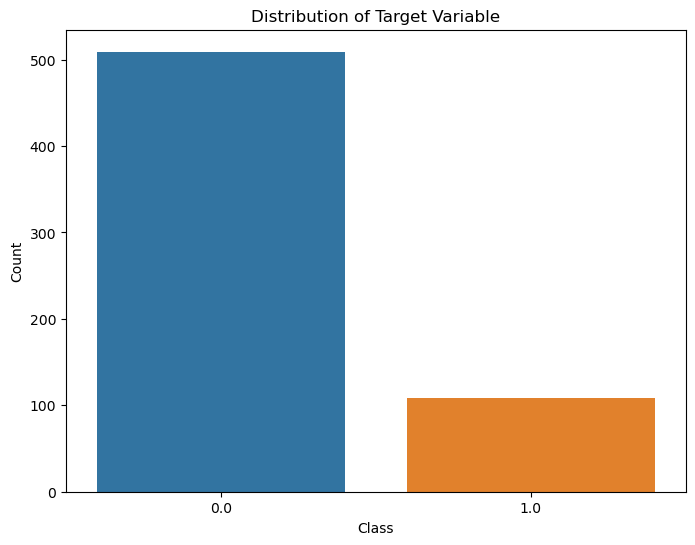

In [169]:
# Visualizations
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

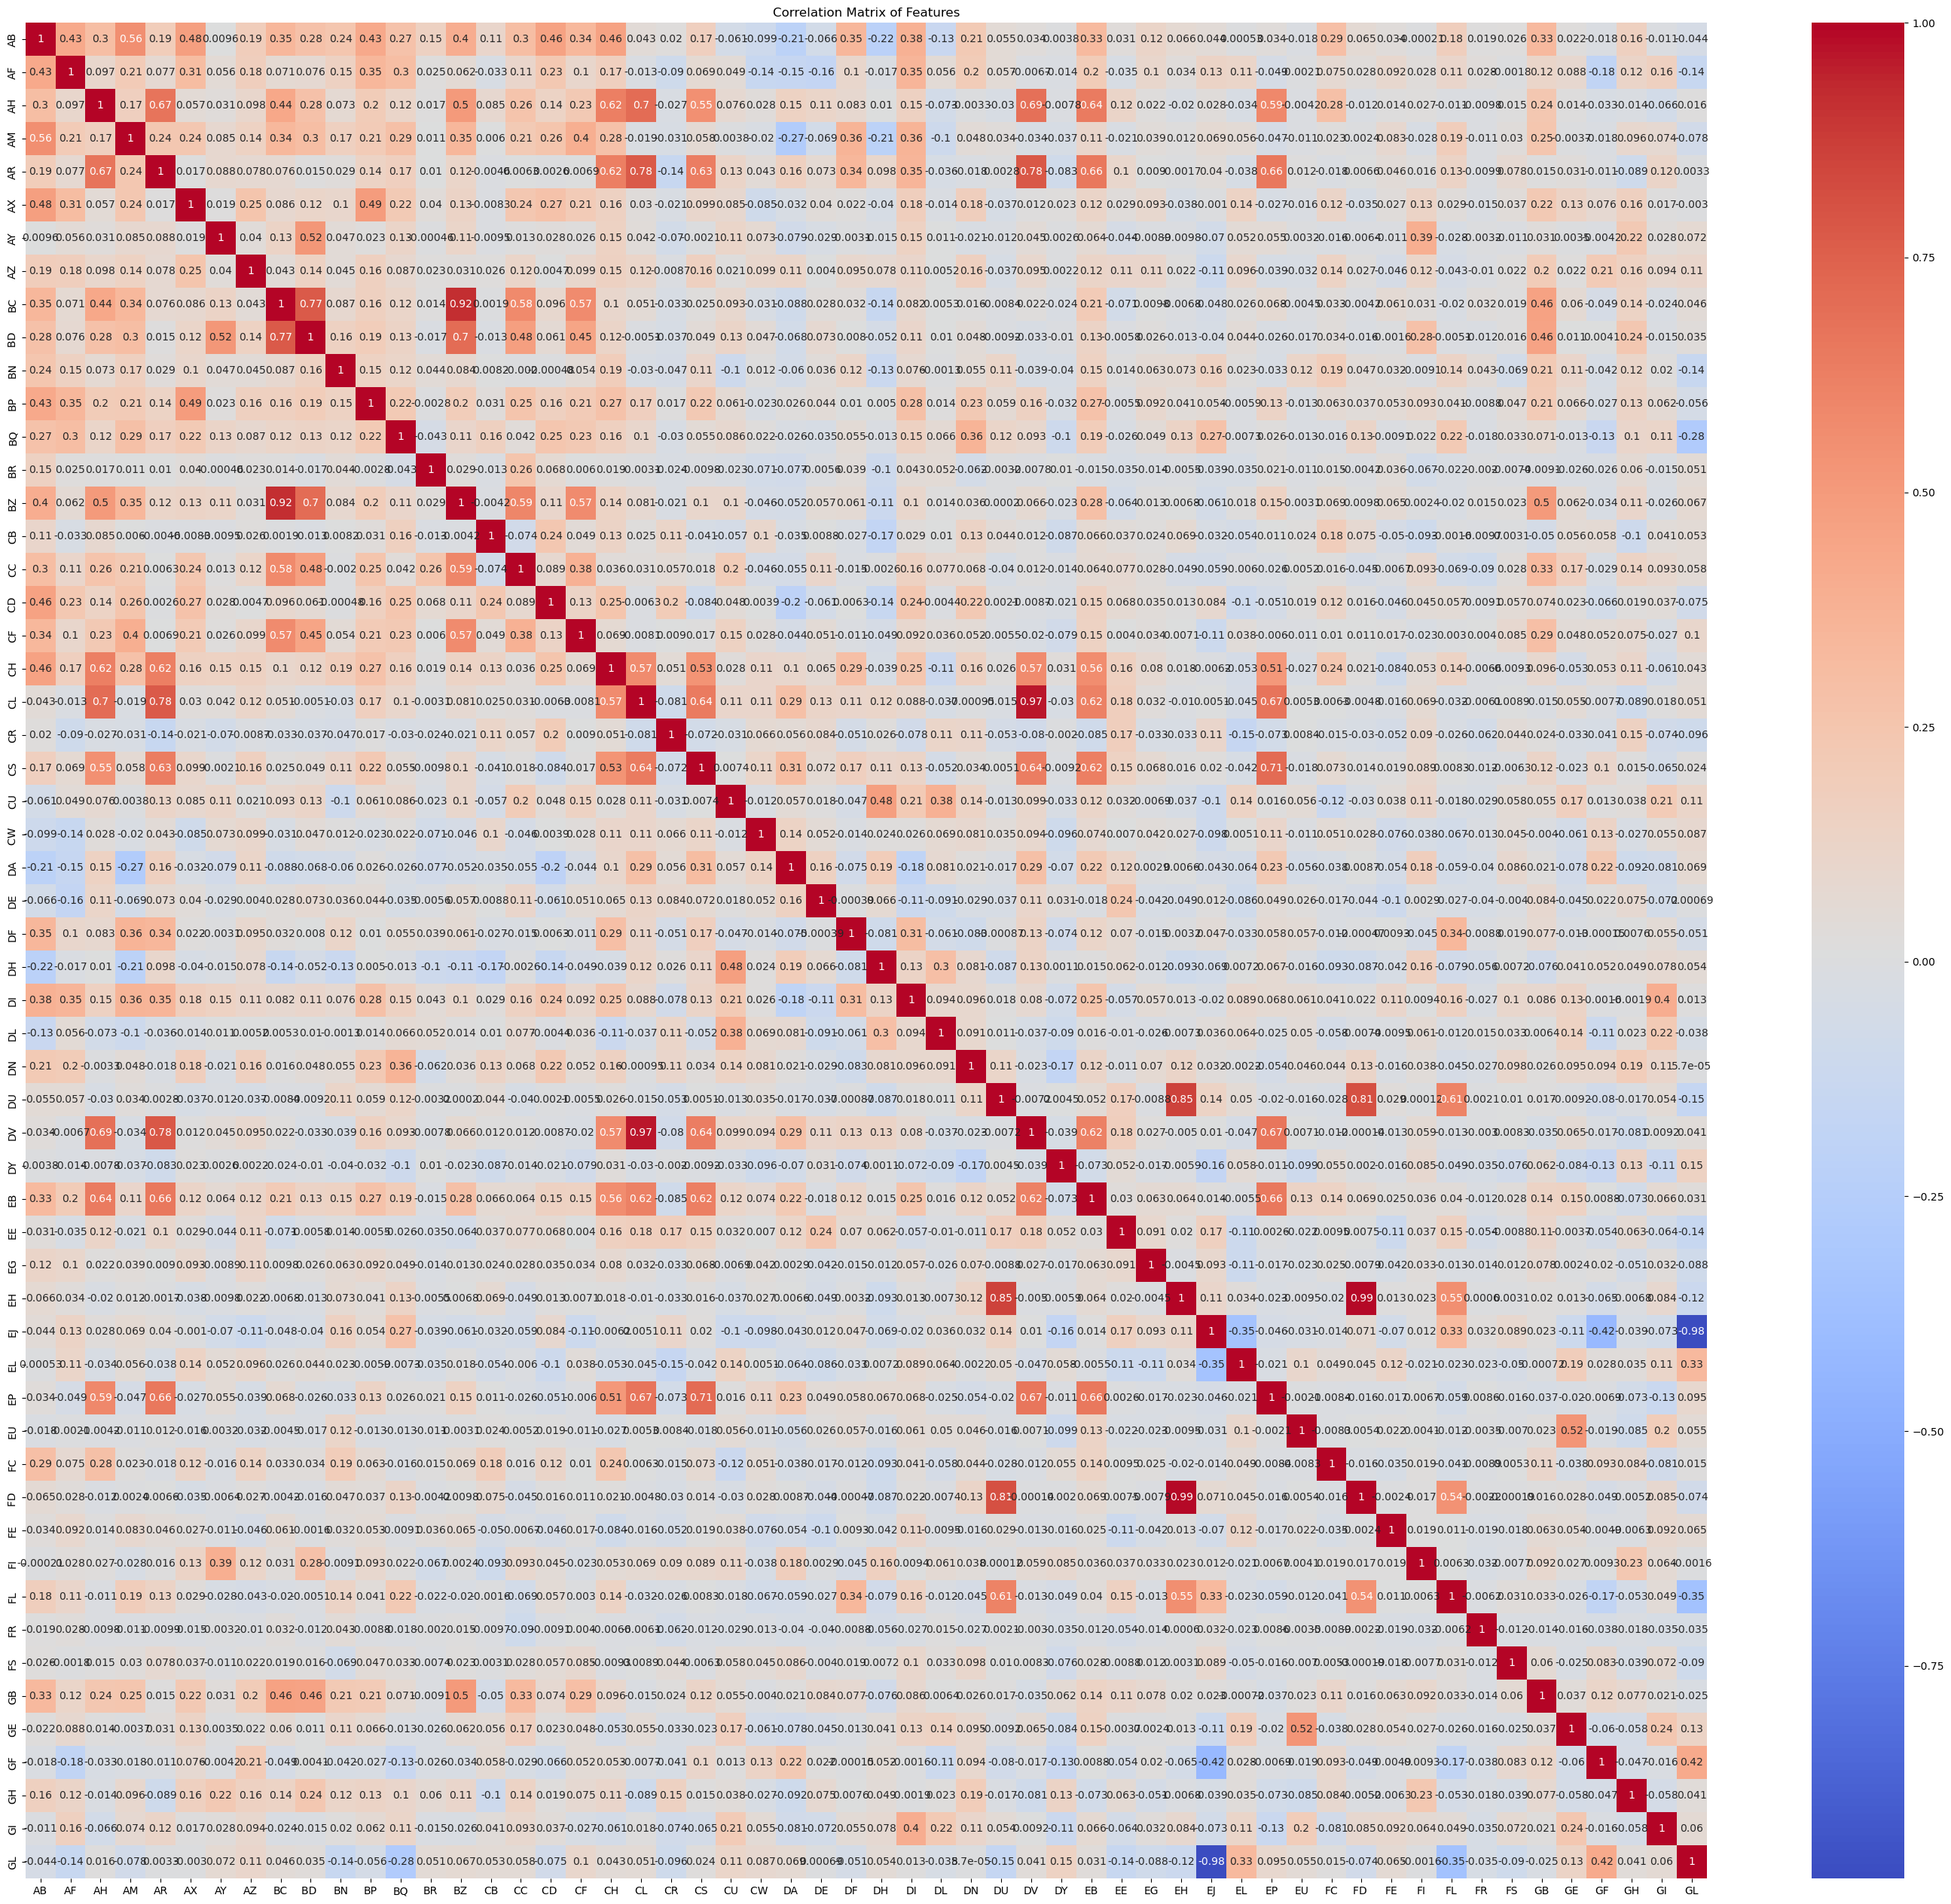

In [170]:
# Visualize the correlation matrix of the features
plt.figure(figsize=(36, 32))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

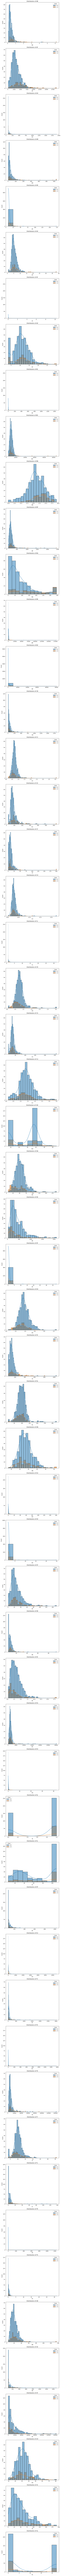

In [171]:
# Visualize the distribution of each numerical feature
num_features = X_train.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(nrows=len(num_features), ncols=1, figsize=(8, 6 * len(num_features)))

for i, feature in enumerate(num_features):
    ax = axes[i]
    sns.histplot(data=X_train, x=feature, hue=y_train, ax=ax, kde=True)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

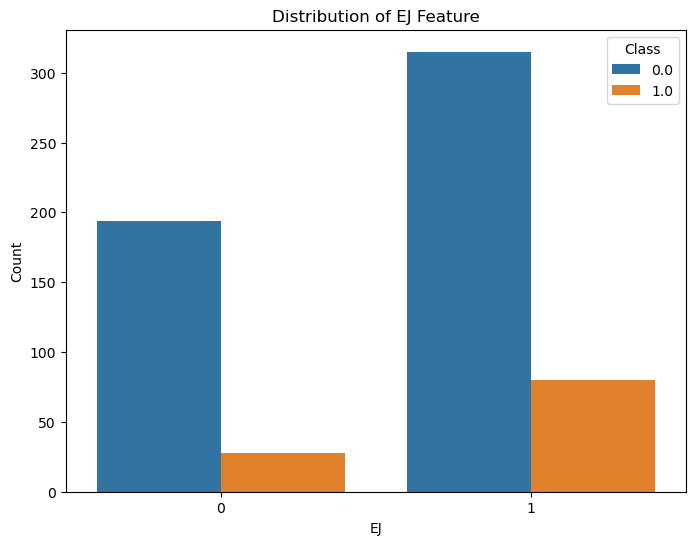

In [172]:
# Visualize the categorical feature EJ
plt.figure(figsize=(8, 6))
sns.countplot(x='EJ', hue='Class', data=train_data)
plt.title('Distribution of EJ Feature')
plt.xlabel('EJ')
plt.ylabel('Count')
plt.show()

In [173]:
# Feature Importance
# Define the preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
    ])

In [174]:
# Define the classifier
classifier = RandomForestClassifier(random_state=42)

In [175]:
# Create a pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [176]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [177]:
# Feature importances from the random forest classifier
feature_importances = pipeline.named_steps['classifier'].feature_importances_

In [178]:
# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

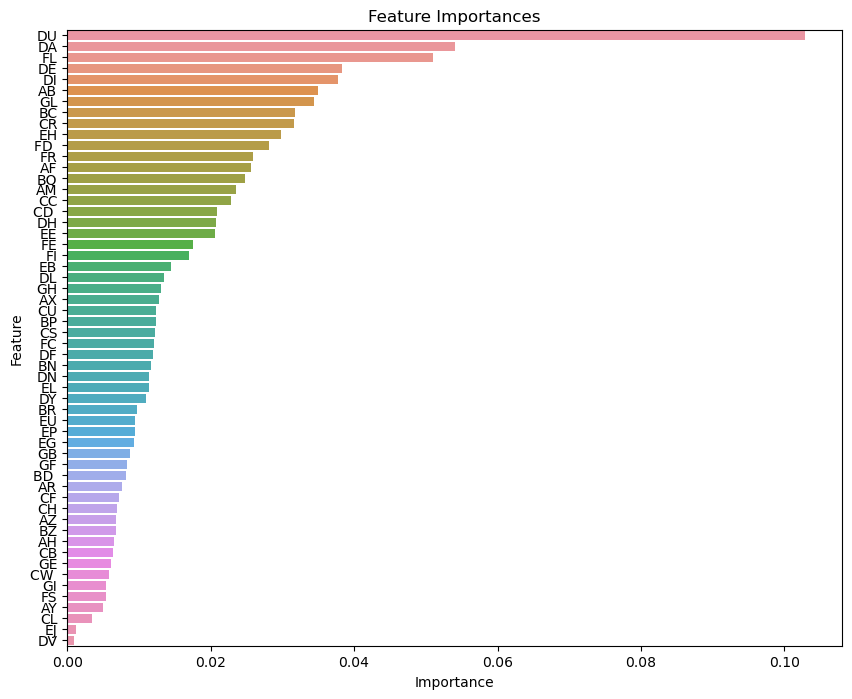

In [179]:
# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [180]:
# Model Training and Evaluation
# Define the pipeline with the best parameters
best_pipeline = pipeline

In [181]:
# Perform cross-validation
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_log_loss')
cv_logloss = -1 * np.mean(cv_scores)
print("Cross-Validation Logarithmic Loss:", cv_logloss)

Cross-Validation Logarithmic Loss: 0.2439172161264039


In [182]:
# Get the pipeline steps and their parameters
pipeline_steps = best_pipeline.steps

In [183]:
# Print the pipeline configuration
print("Pipeline:")
for step_name, step in pipeline_steps:
    print(f"Step: {step_name}")
    step_params = step.get_params()
    if step_params:
        for param_name, param_value in step_params.items():
            print(f"{param_name}: {param_value}")
    else:
        print("No parameters.")
    print()

Pipeline:
Step: preprocessor
n_jobs: None
remainder: drop
sparse_threshold: 0.3
transformer_weights: None
transformers: [('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())]), Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object'))]
verbose: False
verbose_feature_names_out: True
num: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])
num__memory: None
num__steps: [('imputer', SimpleImputer()), ('scaler', StandardScaler())]
num__verbose: False
num__imputer: SimpleImputer()
num__scaler: StandardScaler()
num__imputer__add_indicator: False
num__imputer__copy: True
num__imputer__fill_value: None
nu

In [184]:
# Make predictions on the validation set
y_pred_val = best_pipeline.predict_proba(X_val)

In [185]:
# Evaluate the model using logarithmic loss
logloss = log_loss(y_val, y_pred_val)
print('Validation Logarithmic Loss:', logloss)

Validation Logarithmic Loss: 0.2487211011323269


In [186]:
# Make predictions on the test set
test_features = test_data.drop(['Id', 'Class', 'Alpha'], axis=1)
test_predictions = best_pipeline.predict_proba(test_features)
print('Prediction:', test_predictions)

Prediction: [[0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]
 [0.6 0.4]]


In [187]:
# Prepare submission file
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'class_0': test_predictions[:, 0],
    'class_1': test_predictions[:, 1]
})

In [188]:
# Save submission file
submission.to_csv('submission.csv', index=False)